In [105]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')
plt.style.use('ggplot')
plt.rc('font', size=15)
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline(connected=True) # 온라인이 아닌 상황에서 처리를 위한 명시 코드

from tqdm import tqdm_notebook

from eunjeon import Mecab

from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
import gensim
gensim.__version__  # '3.8.3'

from sklearn.decomposition import PCA

In [31]:
import preprocess_kr

In [32]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [33]:
import warnings
warnings.filterwarnings('ignore')

In [35]:
# 전처리된 정제된 파일을 사용한다.
df = pd.read_table('./data/kr_전지적 독자 시점_episode_total_cleaned_list.txt', header =None)

In [36]:
df.columns = ['Review']
df.head()

,Review
0,전설이 시작된다
1,전독시 소설은 안봤는데 이거 재밌움 웨툰은 일단 존잼
2,나는유중혁이다
3,소설은 완결났길래 이것도 완결 가까워지면 몰아보려고 하는데 지금 전개가 소설 몇화쯤인가요
4,정주행가는중


# mecab 토큰화 및 불용어 제거

In [77]:
def get_tokenized_data(df):
    """
    mecab 형태소 분석기를 이용하여 토큰화 및 불용어 제거하는 함수¶
    """
    
    # 불용어 생성
    stopwords = preprocess_kr.make_stop_words()

    # mecab 형태소 분석기 객체 생성 
    mecab = Mecab('C:/mecab/mecab-ko-dic')

    # 결과 리스트
    tokenized_data = []

    # 원래 진행하고자했던 반복문 for i in range(100)에서 'in' 뒤에 문장을 tqdm()으로 감싸주면 진행 상황이 bar로 표현된다.
    # tqdm_notebook 은 tqdm 의 Jupiter Notebook version, progress bar가 예쁘다.
    for sentence in tqdm_notebook(df['Review']):
        tokenized_sentence = mecab.morphs(sentence) # mecab 문장 토큰화

        stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거    
        stopwords_removed_sentence = [word for word in stopwords_removed_sentence if len(word) > 1] # 한글자 제거

        tokenized_data.append(stopwords_removed_sentence)
        
    return tokenized_data

def show_review_info(tokenized_data):
    """
    리뷰 길이 분포 확인 함수
    """
    print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
    print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
    plt.hist([len(review) for review in tokenized_data], bins=50)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()
    
def get_model_wv(tokenized_data):
    """
    토큰화된 데이터를 Word2Vec 알고리즘을 학습시켜 모델을 반환하는 함수
    """
    # Word2Vec으로 토큰화된 tokenized_data를 학습
    from gensim.models import Word2Vec
    # gensim 4.2 vector_size
    # gensim 3.8.3 size
    model = Word2Vec(sentences = tokenized_data, size = 200, window = 2, min_count = 50, workers = 4, sg = 1)
    
    # embedding_model = Word2Vec(tokenized_contents, size=100, window = 2, min_count=50, workers=4, iter=100, sg=1)
    
    # 포스태깅된 컨텐츠를 100차원의 벡터로 바꿔라. 
    # 주변 단어(window)는 앞뒤로 두개까지 보되, 
    # 코퍼스 내 출현 빈도가 50번 미만인 단어는 분석에서 제외해라. 
    # CPU는 쿼드코어를 쓰고 100번 반복 학습해라. 
    # 분석방법론은 CBOW와 Skip-Gram 중 후자를 선택해라.
    
    # Word2Vec 임베딩 행렬의 크기를 확인
    print("model.wv.vectors.shape: ",model.wv.vectors.shape)
    
    return model    

def print_most_similar_words(model, words_list): 
    """
    특정단어 리스트를 입력받아 유사도를 출력하는 함수
    """
    for keyword in words_list:        
        print('[', keyword, '] 와 관련있는 단어들 :' , model.wv.most_similar(keyword))
        print()
        
def get_similarity_btw_two_words(model, w1,w2):
    """
    단어간 유사도 확인 함수
    """
    
    # 모델로부터 단어벡터를 구한다.
    word_vectors = model.wv
    
    vocabs = word_vectors.vocab.keys()
    word_vectors_list = [word_vectors[v] for v in vocabs]

    # 단어간 유사도를 반환
    return word_vectors.similarity(w1, w2)
        
def get_similarity_df(keyword):
    """
    특정 키워드를 입력받아 관련있는 단어를 찾고 유사도를 구하는 함수
    """
    similar_word = model.wv.most_similar(keyword)
    similar_word_df = pd.DataFrame(similar_word)
    similar_word_df.columns=["유사단어","유사도"]
    similar_word_df
    return similar_word_df   

def plot_2d_graph(vocabs, xs, ys):
    """
    단어와 2차원 X축의 값, Y축의 값을 입력받아 2차원 그래프를 그리는 함수
    """
    plt.figure(figsize=(10,10))
    plt.scatter(xs, ys, marker = 'o')
    for i, v in enumerate(vocabs):
        plt.annotate(v, xy=(xs[i], ys[i]))    
        
def reduce_dimension_PCA(word_vectors_list):
    """
    PCA를 이용하여 차원을 축소하는 함수
    """
    pca = PCA(n_components=2)
    xys = pca.fit_transform(word_vectors_list[:10])
    xs = xys[:,0]
    ys = xys[:,1]
    return xs, ys        

# 1. 토큰화

In [78]:
tokenized_data = get_tokenized_data(df)
tokenized_data[:10]

stop_words made


  0%|          | 0/276161 [00:00<?, ?it/s]

[['전설', '시작'],
 ['전독시', '소설'],
 ['유중혁'],
 ['소설', '완결', '완결', '가까워', '전개', '소설'],
 ['정주', '행가'],
 ['전독시', '웹툰', '소설', '그림', '별론데', '그림', '체고', '독시', '만들', '함하', '사랑'],
 ['작가', '결말'],
 ['전독시',
  '당하',
  '댓글',
  '들어온',
  '화면',
  '확인',
  '수가',
  '답글',
  '제외',
  '답글',
  '유독',
  '답글',
  '보인다면',
  '내용',
  '차단',
  '도록',
  '개꿀',
  '기억',
  '기분',
  '망치',
  '전체',
  '댓글',
  '구분',
  '으므로',
  '장합'],
 ['김독자', '못생긴', '설정'],
 ['주행', '시작']]

# 2. 댓글 정보 확인

리뷰의 최대 길이 : 250
리뷰의 평균 길이 : 4.296826851003582


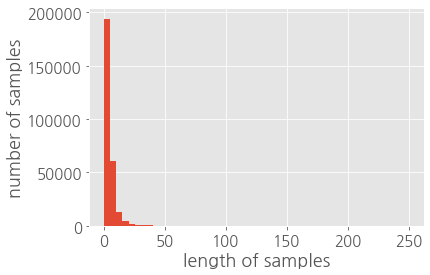

In [79]:
show_review_info(tokenized_data)

# 3. tokenized_data로 모델을 학습

In [80]:
model = get_model_wv(tokenized_data)

model.wv.vectors.shape:  (3086, 200)


In [81]:
# 모델을 저장한다.
model.save('./data/word2vec_kr.model')
 
# 저장한 모델을 읽어온다.
model = Word2Vec.load('./data/word2vec_kr.model')

# 4. 유사단어 검색

In [152]:
words_list = ['독자', '소설', '작가', '그림', '연출', '주인공', '캐릭터', '원작', '작화', '스토리']
print_most_similar_words(model, words_list)

[ 독자 ] 와 관련있는 단어들 : [('김독자', 0.6691325902938843), ('파해', 0.6288113594055176), ('개뿔', 0.6114319562911987), ('아니야', 0.5833918452262878), ('위로', 0.5825196504592896), ('거울', 0.5797582268714905), ('초면', 0.5794005990028381), ('싸늘', 0.5614438652992249), ('바라보', 0.5607392191886902), ('여동생', 0.5529903173446655)]

[ 소설 ] 와 관련있는 단어들 : [('행중', 0.745009183883667), ('행하', 0.7293678522109985), ('원작', 0.723612368106842), ('감회', 0.7210447788238525), ('넘어갔', 0.6974616646766663), ('정독', 0.694442629814148), ('더라구요', 0.6916889548301697), ('잔데', 0.6906082630157471), ('빠져서', 0.6905902624130249), ('봐야겠다', 0.6878035068511963)]

[ 작가 ] 와 관련있는 단어들 : [('신가요', 0.6417890787124634), ('숑님', 0.5916523933410645), ('체도', 0.5731692314147949), ('컴퓨터', 0.5711233615875244), ('택배', 0.5700432062149048), ('체로', 0.5669181942939758), ('만수무강', 0.5665484070777893), ('계신', 0.564110279083252), ('손목', 0.560725212097168), ('오래오래', 0.5542482137680054)]

[ 그림 ] 와 관련있는 단어들 : [('작화', 0.7883106470108032), ('체가', 0.6929625272750854), ('체도',

#  5. 단어간 유사도 확인(동작 안 함)

In [156]:
# get_similarity_btw_two_words(model, '김독자 ','한수영')

# 6. 유사단어와 유사도를 데이터프레임으로 확인

In [153]:
words_list

['독자', '소설', '작가', '그림', '연출', '주인공', '캐릭터', '원작', '작화', '스토리']

In [187]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import chart_studio.plotly as py
import plotly
import cufflinks as cf
import pandas as pd
import numpy as np

for word in words_list:
    
    similar_word_df = get_similarity_df(word)
    fig = similar_word_df.iplot(kind='pie',labels = "유사단어", 
                                    values="유사도", textinfo="percent+label",
                                    title= word + ' 관련 단어 Top10', hole = 0.5, asFigure=True)
    filename = './data/'+ word + '.html'   
    plotly.offline.plot(fig,filename=filename)
    fig.show()

# 7. PCA 차원 축소 및 유사도 시각화(동작 안 함)

In [157]:
# xs, ys = reduce_dimension_PCA(word_vectors_list)
# plot_2d_graph(vocabs, xs, ys)